<a href="https://colab.research.google.com/github/vartikatrao/PyTorch/blob/main/BinaryClassfication_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import sklearn
from sklearn.datasets import make_circles

n_samples= 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [124]:
len(X), len(y)

(1000, 1000)

In [125]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [126]:
import pandas as pd
circles= pd.DataFrame({"X1": X[:, 0], "X2": X[:,1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


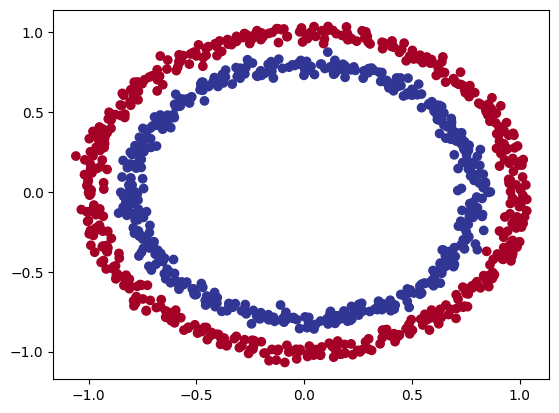

In [127]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y= X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [128]:
X.shape , y.shape

((1000, 2), (1000,))

In [129]:
import torch
torch.__version__

'2.0.1+cu118'

In [130]:
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy (y).type(torch.float)

In [131]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

In [132]:
len(X_train), len(X_test)

(800, 200)

In [133]:
n_samples

1000

In [134]:
import torch
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [135]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1= nn.Linear(in_features=2, out_features=5)
    self.layer_2= nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [136]:
model_0= CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [137]:
device

'cuda'

In [138]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [139]:
model_0= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear (in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [140]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [141]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(params= model_0.parameters(), lr= 0.1)

In [142]:
#Calculate accuracy
def accuracy_fn (y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred))* 100
  return acc

### Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** to **prediction probabilites** by passing them through some kind of activation function for exampple, sigmoid- binary classification and softmax- multi class classification

Then we can convert the **prediction probabilities** to **prediction labels** by either rounding them or taking the `argmax()`


In [143]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [144]:
# use the sigmoid activation function
y_pred_probs= torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [145]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [146]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Training and Testing

In [147]:
device

'cuda'

In [148]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs =100


X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

for epoch in range (epochs):
  ### Training
  model_0.train()

  # predict
  y_logits= model_0(X_train).squeeze()
  y_pred= torch.round(torch.sigmoid(y_logits))

  # loss
  loss= loss_fn(y_logits, y_train)
  acc= accuracy_fn(y_train, y_pred= y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits=  model_0(X_test).squeeze()
    test_preds= torch.round(torch.sigmoid(test_logits))

    test_loss= loss_fn (test_logits, y_test)
    test_acc= accuracy_fn (y_test, y_pred= test_preds)

  if epoch%10==0:
    print(f"Epoch:{epoch}   |    Loss:  {loss:.5f},  Acc: { acc:.2f}%  |   Test loss {test_loss:.5f}  , Acc: {test_acc: .2f}%")



Epoch:0   |    Loss:  0.69796,  Acc: 51.88%  |   Test loss 0.69440  , Acc:  58.00%
Epoch:10   |    Loss:  0.69590,  Acc: 51.25%  |   Test loss 0.69305  , Acc:  53.00%
Epoch:20   |    Loss:  0.69490,  Acc: 51.62%  |   Test loss 0.69254  , Acc:  49.50%
Epoch:30   |    Loss:  0.69435,  Acc: 51.12%  |   Test loss 0.69236  , Acc:  49.50%
Epoch:40   |    Loss:  0.69401,  Acc: 50.88%  |   Test loss 0.69232  , Acc:  51.00%
Epoch:50   |    Loss:  0.69378,  Acc: 50.25%  |   Test loss 0.69234  , Acc:  50.00%
Epoch:60   |    Loss:  0.69362,  Acc: 50.00%  |   Test loss 0.69239  , Acc:  51.50%
Epoch:70   |    Loss:  0.69351,  Acc: 50.25%  |   Test loss 0.69246  , Acc:  51.00%
Epoch:80   |    Loss:  0.69342,  Acc: 49.88%  |   Test loss 0.69254  , Acc:  50.00%
Epoch:90   |    Loss:  0.69336,  Acc: 49.88%  |   Test loss 0.69262  , Acc:  53.00%


In [149]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


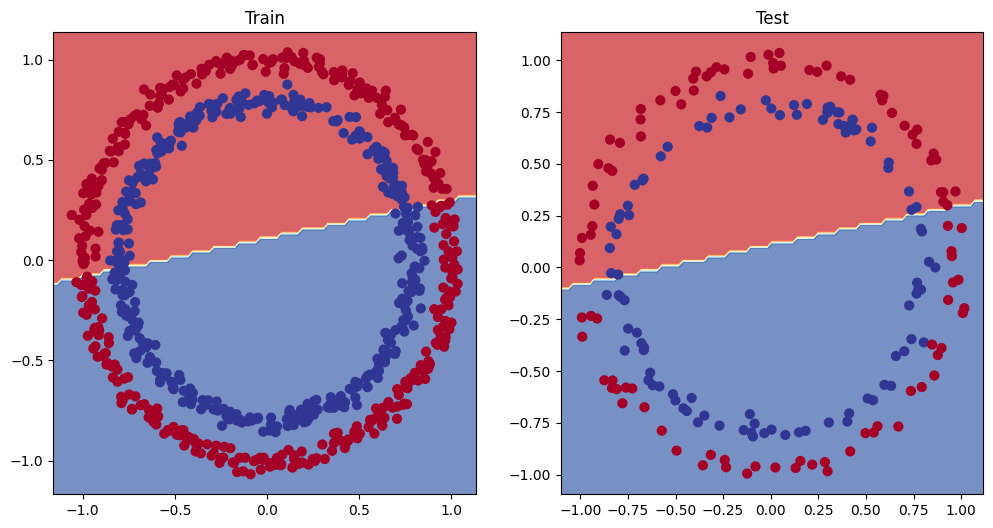

In [150]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving model **Hyperparameters**

- Add more layers
- add more hidden layers
- fit for longer
- change the activation function
- Change the optimizer
- Change the lr
- Change the loss function


increating number of hidden units
increase number of layers
increase number of epochs

In [151]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1= nn.Linear(in_features=2, out_features=10)
    self.layer_2= nn.Linear(in_features=10, out_features=10)
    self.layer_3= nn.Linear (in_features=10, out_features= 1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [152]:
model_1= CircleModelV1().to(device)

In [153]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [154]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

for epoch in range (epochs):
  ### Training
  model_1.train()

  # predict
  y_logits= model_1(X_train).squeeze()
  y_pred= torch.round(torch.sigmoid(y_logits))

  # calculate loss
  loss= loss_fn(y_logits, y_train)
  acc = accuracy_fn (y_train, y_pred)

  # optimizer zero_grad
  optimizer.zero_grad()

  # back propagation
  loss.backward()

  # optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits= model_1(X_test).squeeze()
    test_preds= torch.round(torch.sigmoid(test_logits))

    test_loss= loss_fn(test_logits, y_test)
    test_acc= accuracy_fn (y_test, test_preds)

  if epoch%10==0:
    print(f"Epoch:{epoch}   |    Loss:  {loss:.5f},  Acc: { acc:.2f}%  |   Test loss {test_loss:.5f}  , Acc: {test_acc: .2f}%")



Epoch:0   |    Loss:  0.69396,  Acc: 50.88%  |   Test loss 0.69261  , Acc:  51.00%
Epoch:10   |    Loss:  0.69369,  Acc: 50.25%  |   Test loss 0.69270  , Acc:  50.00%
Epoch:20   |    Loss:  0.69351,  Acc: 50.12%  |   Test loss 0.69283  , Acc:  49.50%
Epoch:30   |    Loss:  0.69339,  Acc: 50.50%  |   Test loss 0.69297  , Acc:  48.00%
Epoch:40   |    Loss:  0.69329,  Acc: 50.38%  |   Test loss 0.69310  , Acc:  49.00%
Epoch:50   |    Loss:  0.69322,  Acc: 49.88%  |   Test loss 0.69324  , Acc:  50.00%
Epoch:60   |    Loss:  0.69317,  Acc: 49.38%  |   Test loss 0.69336  , Acc:  51.50%
Epoch:70   |    Loss:  0.69312,  Acc: 49.38%  |   Test loss 0.69348  , Acc:  50.50%
Epoch:80   |    Loss:  0.69309,  Acc: 50.12%  |   Test loss 0.69359  , Acc:  50.00%
Epoch:90   |    Loss:  0.69307,  Acc: 50.50%  |   Test loss 0.69370  , Acc:  48.50%
Epoch:100   |    Loss:  0.69305,  Acc: 50.38%  |   Test loss 0.69379  , Acc:  48.00%
Epoch:110   |    Loss:  0.69303,  Acc: 50.88%  |   Test loss 0.69388  , Acc:

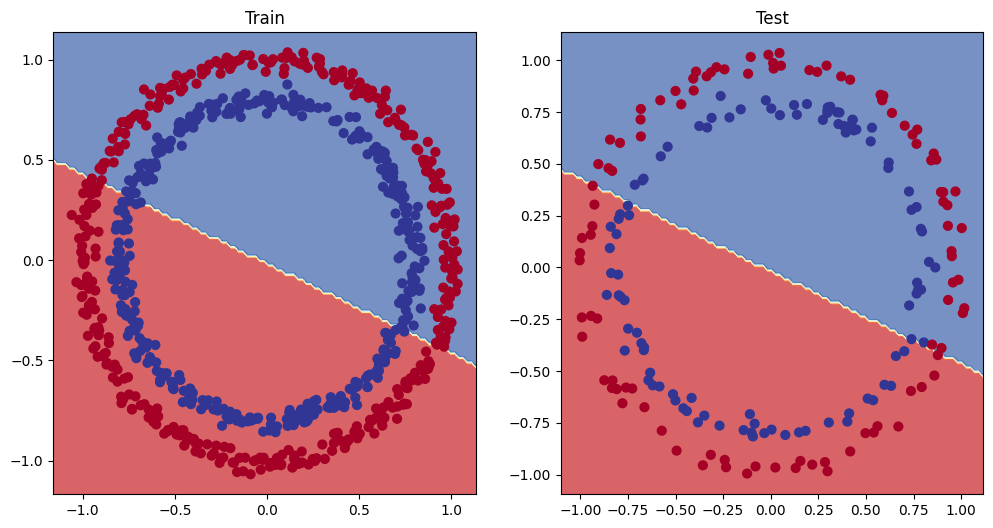

In [155]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [156]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2= nn.Linear (in_features=10, out_features=10 )
    self.layer3= nn.Linear (in_features= 10, out_features=1)
    self.relu= nn.ReLU()

  def forward (self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3= CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [157]:
#setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(params= model_3.parameters(), lr=0.1 )

In [158]:
model_3.to(device)

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## Training and Testing

In [159]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)
epochs= 2000
for epoch in range (epochs):
  ### training
  model_3.train()

  # predict
  y_logits= model_3(X_train).squeeze()
  y_preds= torch.round(torch.sigmoid(y_logits))

  # calculate loss
  loss = loss_fn (y_logits, y_train)
  acc= accuracy_fn (y_train, y_preds)

  # optimizer zero grad
  optimizer.zero_grad()

  # back propagation
  loss.backward()

  # optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits= model_3(X_test).squeeze()
    test_preds= torch.round(torch.sigmoid(test_logits))

    test_loss= loss_fn (test_logits, y_test)
    test_acc= accuracy_fn (y_test, test_preds)
  if epoch%10==0:
    print(f"Epoch:{epoch}   |    Loss:  {loss:.5f},  Acc: { acc:.2f}%  |   Test loss {test_loss:.5f}  , Acc: {test_acc: .2f}%")

Epoch:0   |    Loss:  0.69295,  Acc: 50.00%  |   Test loss 0.69319  , Acc:  50.00%
Epoch:10   |    Loss:  0.69248,  Acc: 50.50%  |   Test loss 0.69260  , Acc:  50.00%
Epoch:20   |    Loss:  0.69225,  Acc: 59.13%  |   Test loss 0.69231  , Acc:  56.50%
Epoch:30   |    Loss:  0.69209,  Acc: 70.25%  |   Test loss 0.69212  , Acc:  68.00%
Epoch:40   |    Loss:  0.69195,  Acc: 68.38%  |   Test loss 0.69195  , Acc:  71.00%
Epoch:50   |    Loss:  0.69181,  Acc: 58.25%  |   Test loss 0.69177  , Acc:  58.00%
Epoch:60   |    Loss:  0.69168,  Acc: 54.00%  |   Test loss 0.69161  , Acc:  54.50%
Epoch:70   |    Loss:  0.69155,  Acc: 53.12%  |   Test loss 0.69146  , Acc:  53.00%
Epoch:80   |    Loss:  0.69141,  Acc: 52.62%  |   Test loss 0.69132  , Acc:  53.00%
Epoch:90   |    Loss:  0.69128,  Acc: 52.75%  |   Test loss 0.69117  , Acc:  53.00%
Epoch:100   |    Loss:  0.69115,  Acc: 52.88%  |   Test loss 0.69102  , Acc:  52.50%
Epoch:110   |    Loss:  0.69103,  Acc: 52.88%  |   Test loss 0.69088  , Acc:

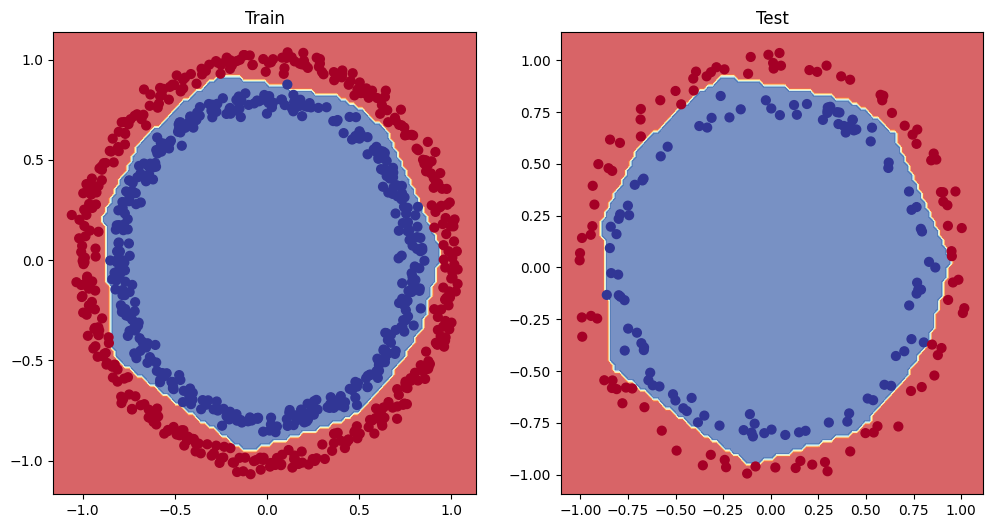

In [160]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)